In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import *
import cv2
import numpy as np
from lane_detection import detect_lane, detect_edges, region_of_interest, detect_line_segments, average_slope_intercept
from heading import *
import math
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
images_dir = Path('CarlaData/images').resolve()
files = list(images_dir.glob('*.png'))
files.sort()
files

[PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/01.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/02.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/03.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/04.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/05.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/06.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/07.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/08.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/09.png'),
 PosixPath('/Users/davidkorcak/Documents/porsche_contest/porsche_hackaton/CarlaData/images/

In [165]:
def load_frame(imname, cvt_color=True):
    img = cv2.imread(str(imname))
    if cvt_color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

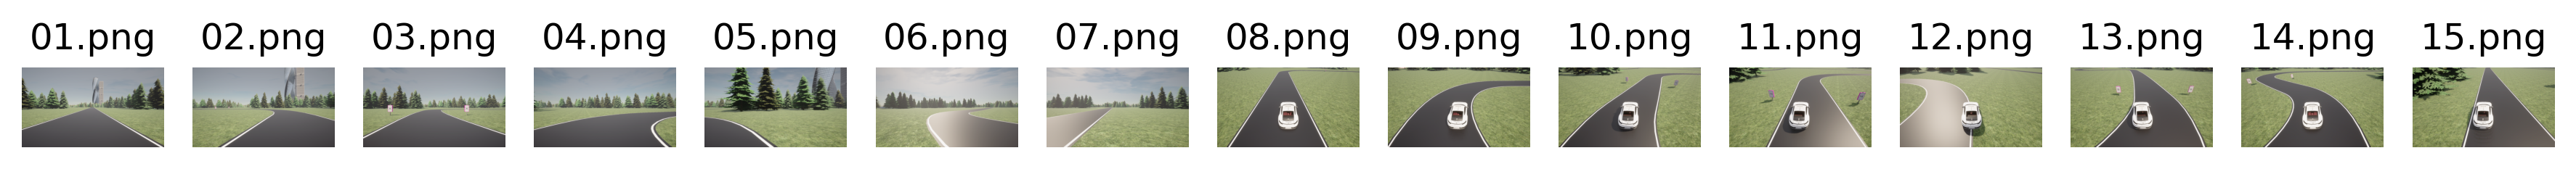

In [166]:
# show images
fig, ax = plt.subplots(1, len(files), figsize=(15, 5), dpi=300)
for i, f in enumerate(files):
    img = load_frame(f)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f.name)
plt.show()

In [127]:
frame = cv2.imread(files[8].as_posix())
display_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
print(frame.shape)
frame = cv2.resize(frame, (640, 480), interpolation=cv2.INTER_AREA)
edges, mask = detect_edges(frame, return_mask=True)
cropped_edges = region_of_interest(edges)
cropped_mask = region_of_interest(mask)
line_segments = detect_line_segments(cropped_edges)

(720, 1280, 3)


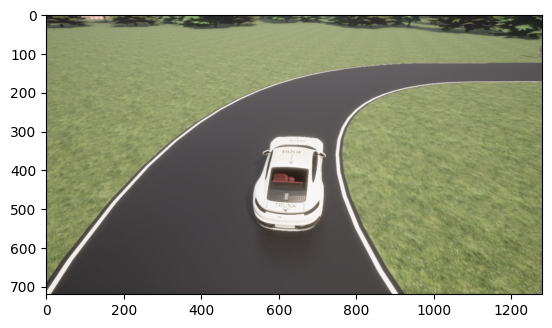

In [128]:
plt.imshow(display_image)

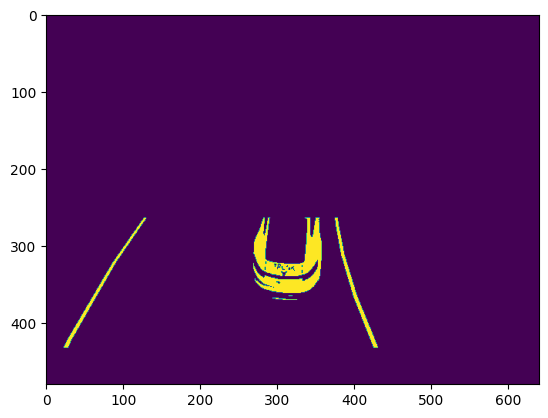

In [129]:
plt.imshow(cropped_mask)

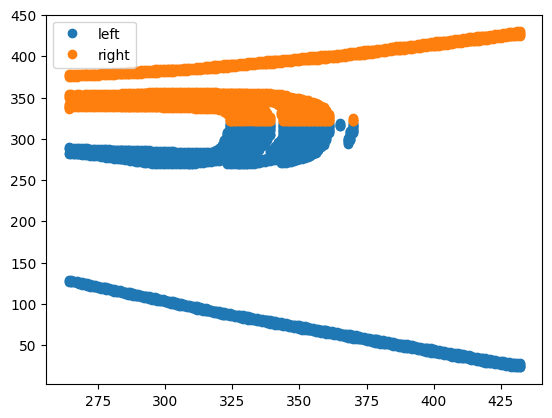

In [130]:
# convert cropped mask to x,y tuples and split into left and right
points = np.argwhere(cropped_mask>0)
points_left = points[points[:,1]<cropped_mask.shape[1]//2]
points_right = points[points[:,1]>cropped_mask.shape[1]//2]
plt.plot(points_left[:, 0], points_left[:, 1], 'o', label='left')
plt.plot(points_right[:, 0], points_right[:, 1], 'o', label='right')
plt.legend()

In [131]:
def average_y_for_unique_x(points):
    # Separate the X and Y values
    x_values = points[:, 0]
    y_values = points[:, 1]

    # Find the unique X values
    unique_x = np.unique(x_values)

    # Compute the average Y for each unique X
    averaged_points = np.array(
        [[x, np.mean(y_values[x_values == x])] for x in unique_x])

    return averaged_points

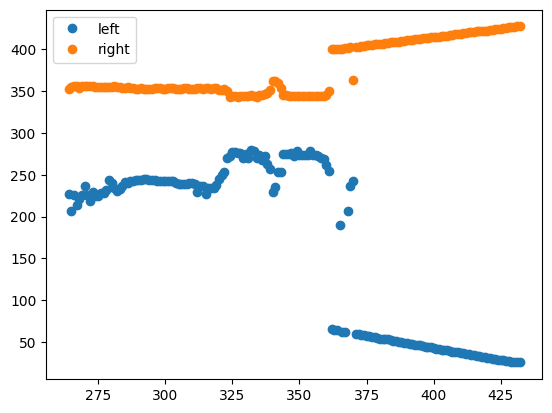

In [132]:
# get the average y for each unique x
left_for_interp = average_y_for_unique_x(points_left)
right_for_interp = average_y_for_unique_x(points_right)
plt.plot(left_for_interp[:, 0], left_for_interp[:, 1], 'o', label='left')
plt.plot(right_for_interp[:, 0], right_for_interp[:, 1], 'o', label='right')
plt.legend()

In [137]:
# fit a polynomial to the left and right points
left_poly = np.polyfit(left_for_interp[:, 0], left_for_interp[:, 1], 2)
right_poly = np.polyfit(right_for_interp[:, 0], right_for_interp[:, 1], 2)
print(left_poly)
print(right_poly)
center_poly = (left_poly + right_poly) / 2
center_poly

[-1.61806513e-02  9.58633939e+00 -1.17093767e+03]
[ 5.03157513e-03 -2.95680720e+00  7.84768793e+02]


array([-5.5745381e-03,  3.3147661e+00, -1.9308444e+02])

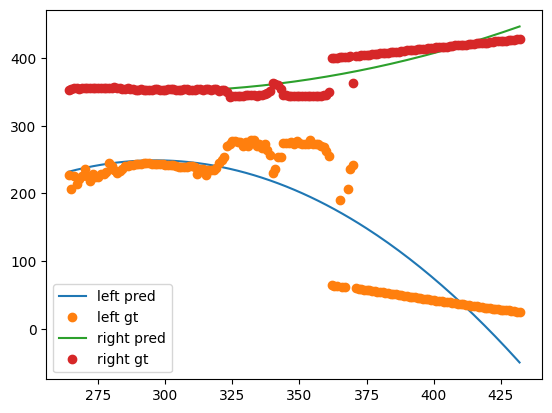

In [134]:
left_linspace = np.linspace(left_for_interp[:, 0].min(), left_for_interp[:, 0].max(), left_for_interp.shape[0]) 
right_linspace = np.linspace(right_for_interp[:, 0].min(), right_for_interp[:, 0].max(), right_for_interp.shape[0])
left_poly_points = np.polyval(left_poly, left_linspace)
right_poly_points = np.polyval(right_poly, right_linspace)
plt.plot(left_linspace, left_poly_points, label='left pred')
plt.plot(left_for_interp[:, 0], left_for_interp[:, 1], 'o', label='left gt')
plt.plot(right_linspace, right_poly_points, label='right pred')
plt.plot(right_for_interp[:, 0], right_for_interp[:, 1], 'o', label='right gt')
plt.legend()

In [135]:
larger_min_x = max(left_for_interp[:, 0].min(), right_for_interp[:, 0].min())
smaller_max_x = min(left_for_interp[:, 0].max(), right_for_interp[:, 0].max())
centerline_x = left_for_interp[ (left_for_interp[:, 0] > larger_min_x) & (left_for_interp[:, 0] < smaller_max_x)][:, 0]

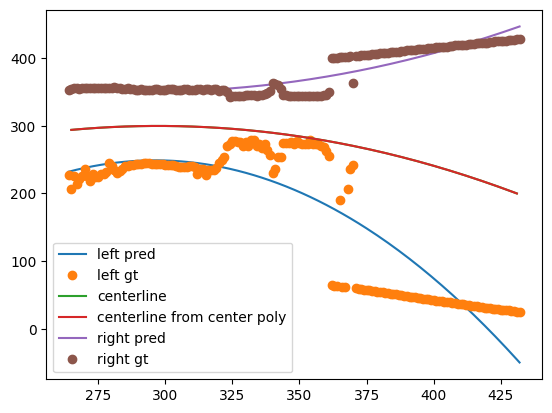

In [138]:
centerline = (np.polyval(left_poly, centerline_x) + np.polyval(right_poly, centerline_x)) / 2
centerline_from_center_poly = np.polyval(center_poly, centerline_x)
plt.plot(left_linspace, left_poly_points, label='left pred')
plt.plot(left_for_interp[:, 0], left_for_interp[:, 1], 'o', label='left gt')
plt.plot(centerline_x, centerline, label='centerline')
plt.plot(centerline_x, centerline_from_center_poly, label='centerline from center poly')
plt.plot(right_linspace, right_poly_points, label='right pred')
plt.plot(right_for_interp[:, 0], right_for_interp[:, 1], 'o', label='right gt')
plt.legend()

In [333]:
from center_line import CenterLinePredictor

predictor = CenterLinePredictor()

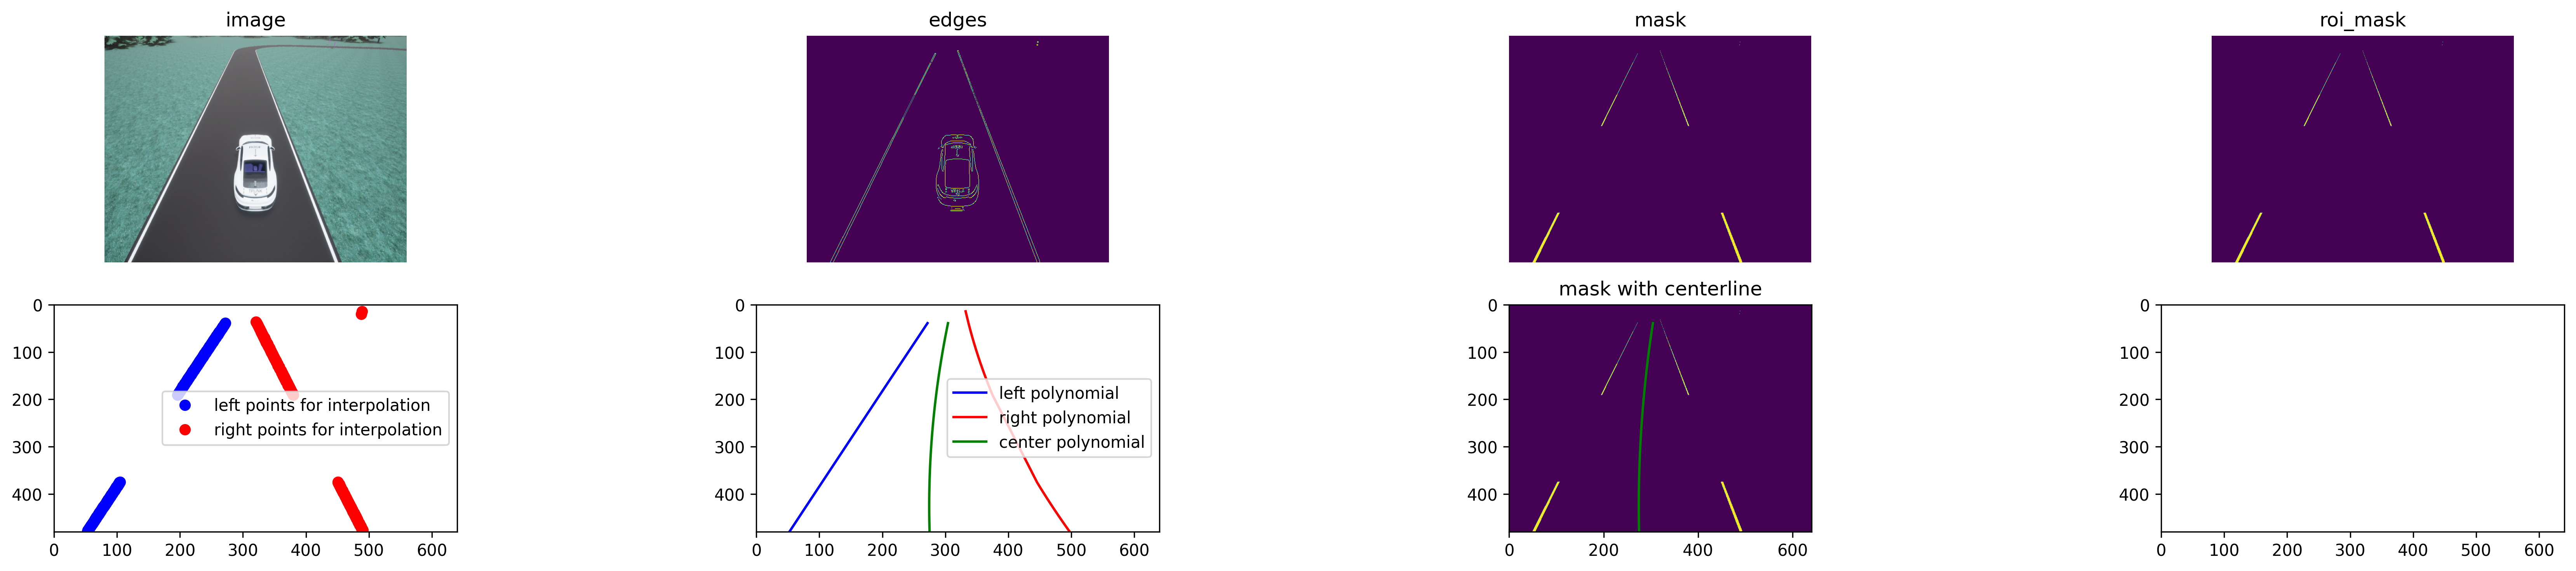

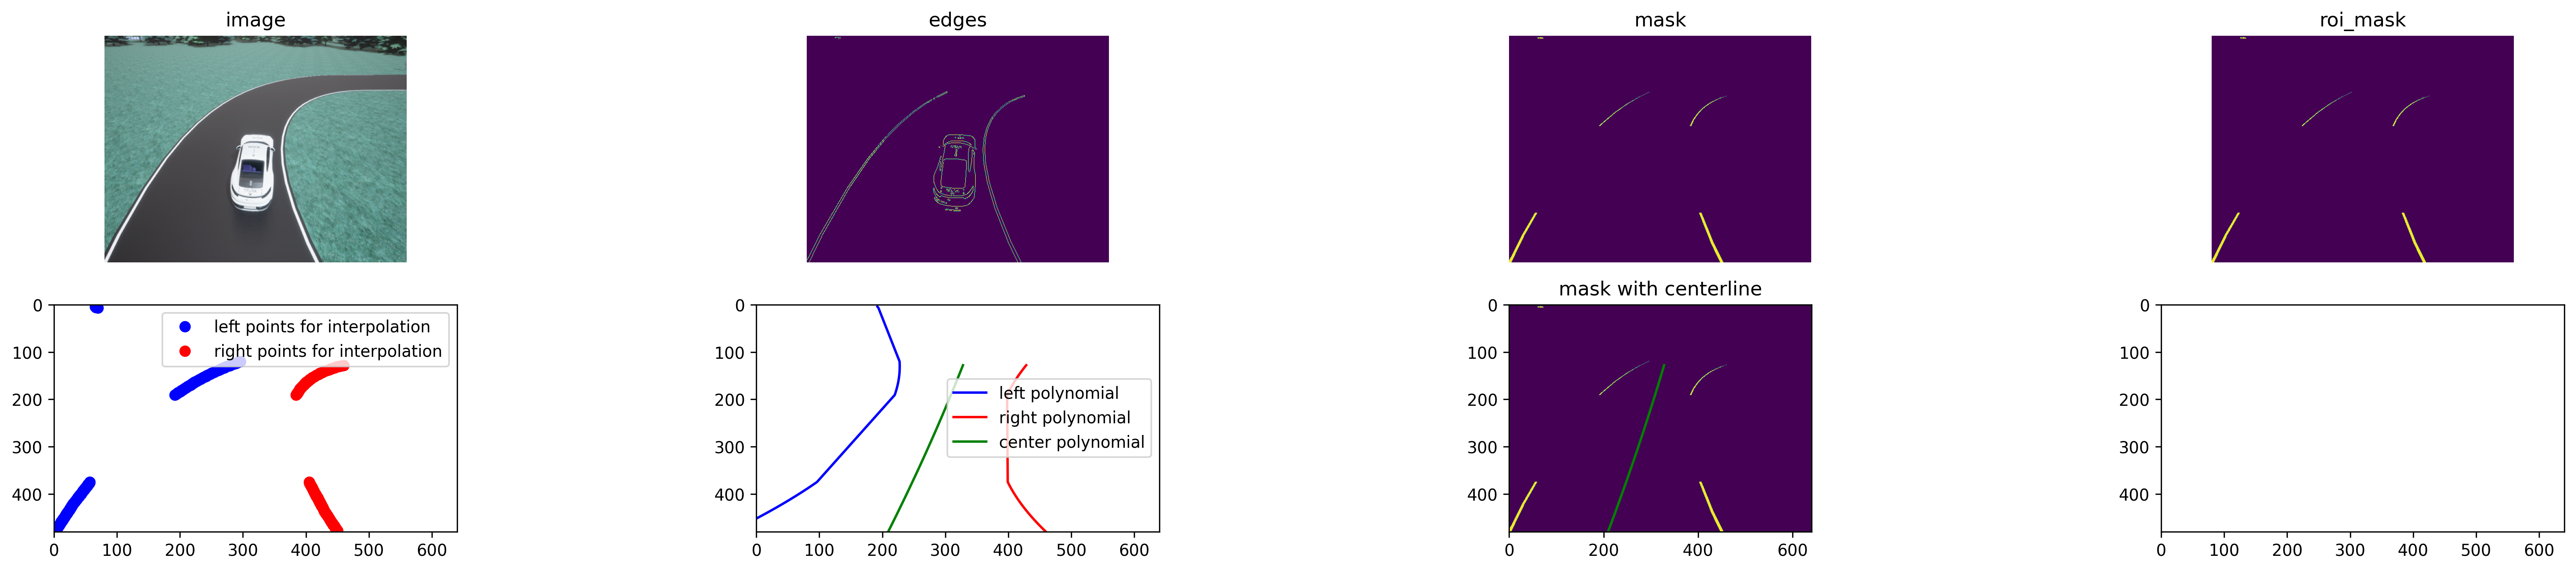

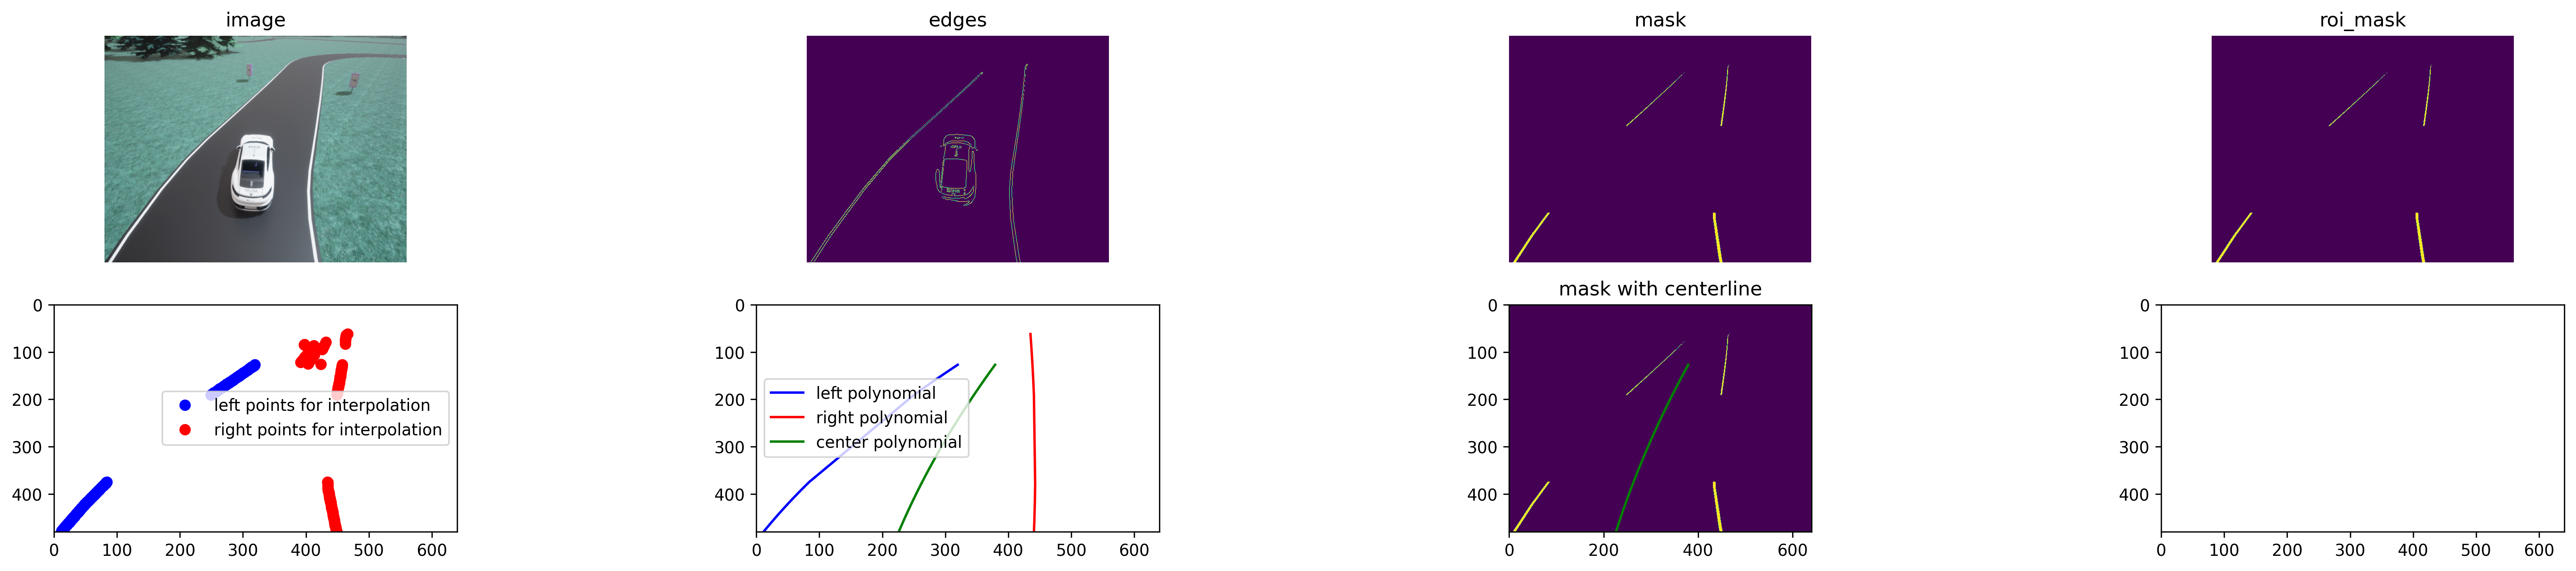

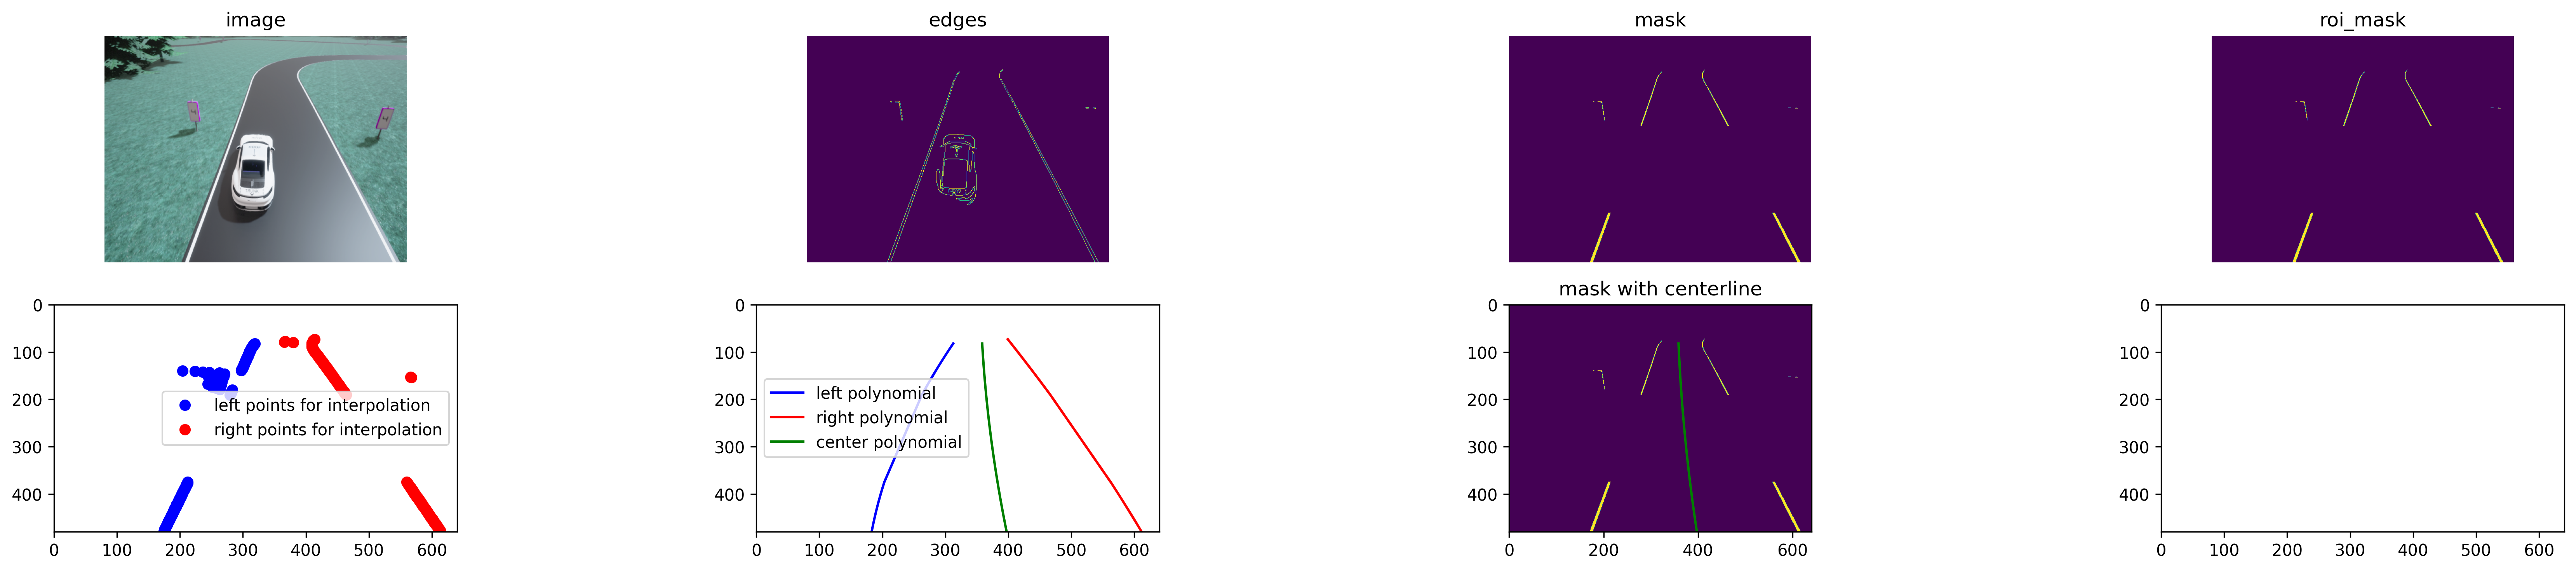

too many indices for array: array is 1-dimensional, but 2 were indexed


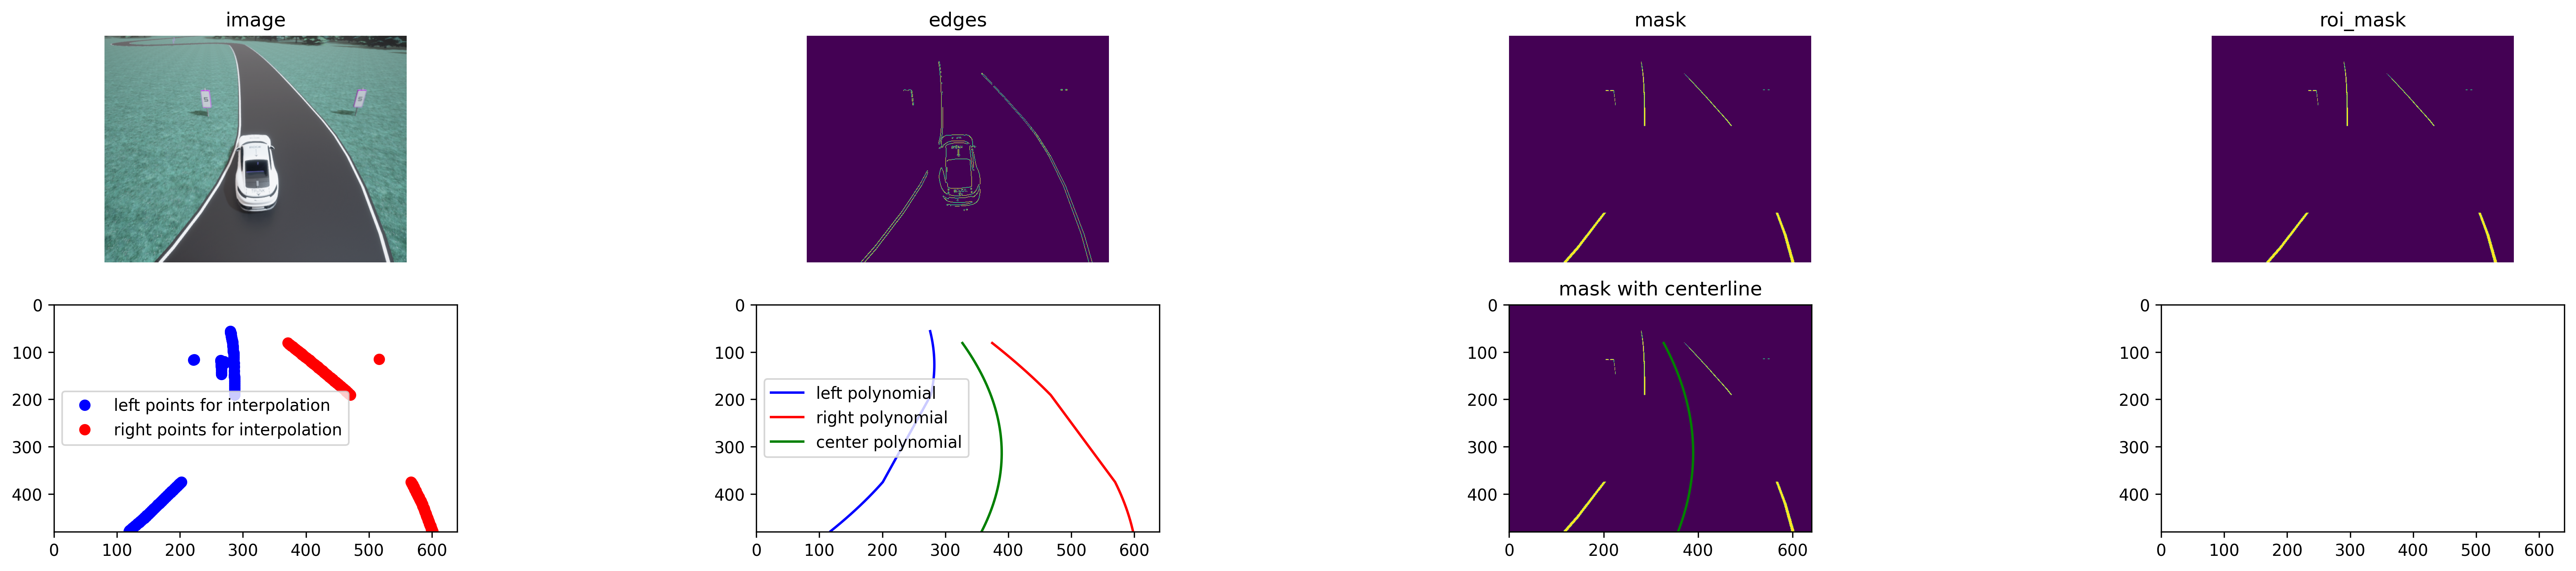

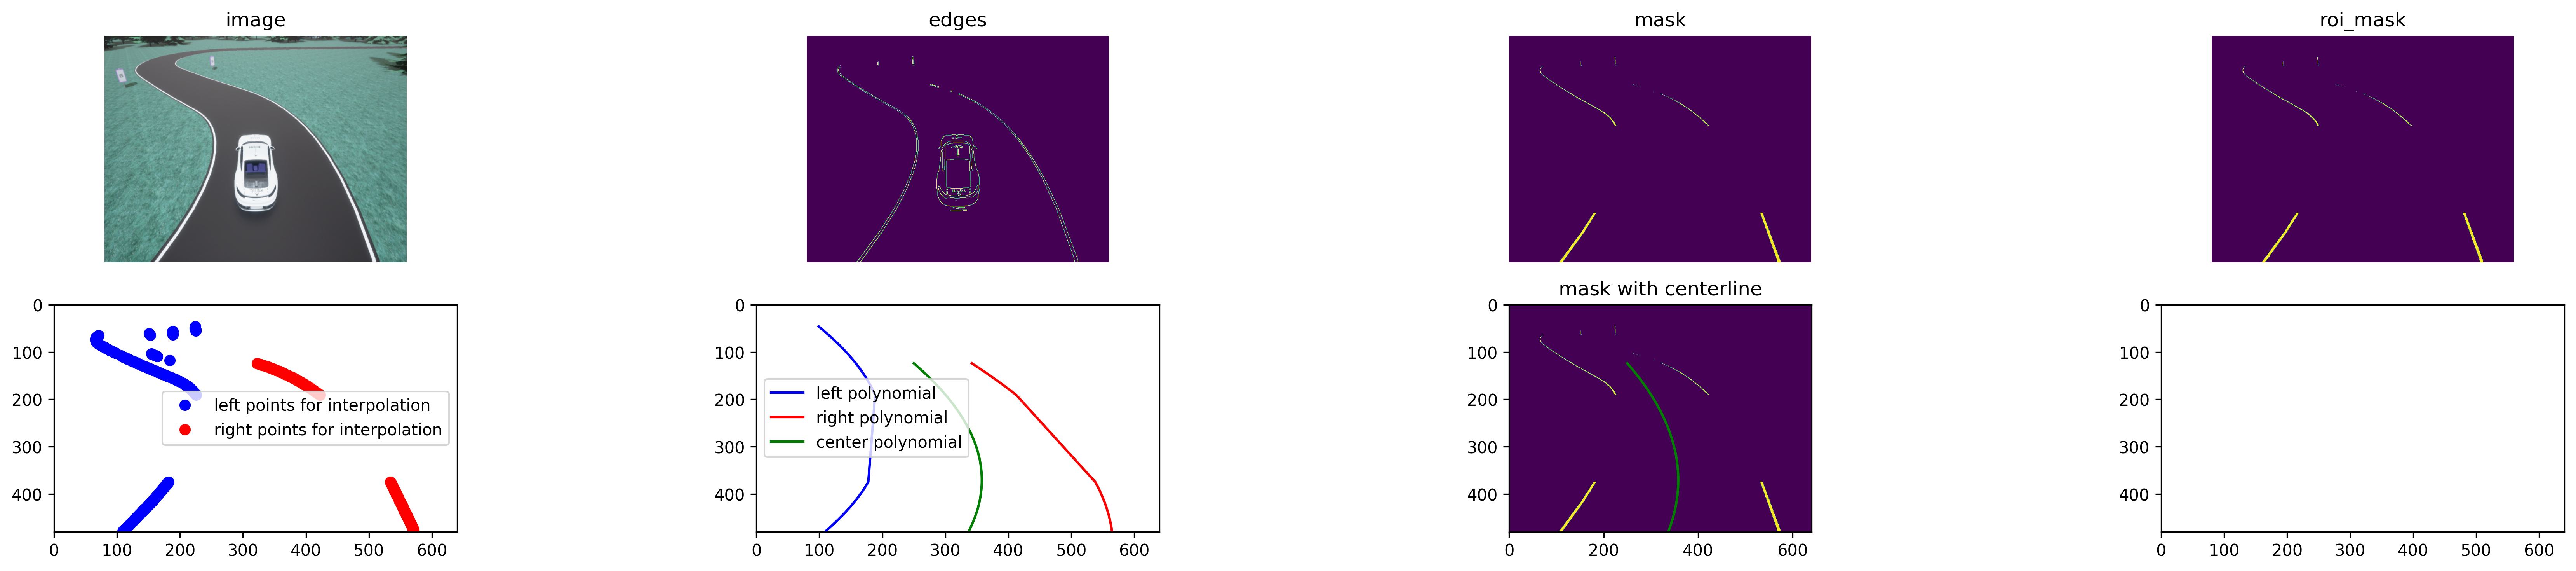

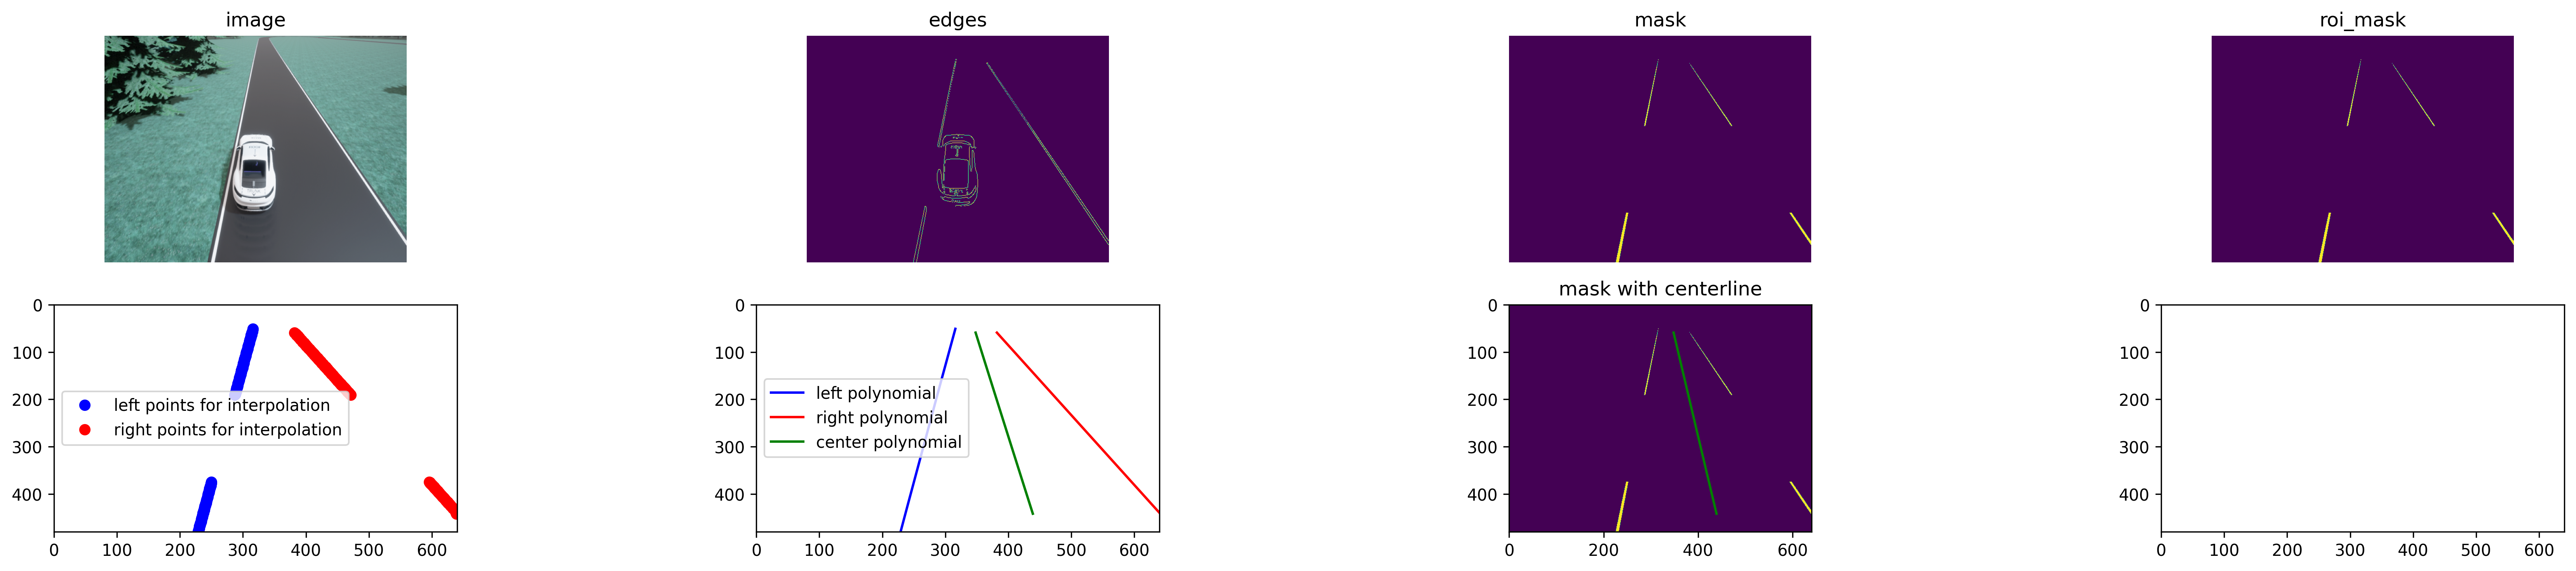

In [334]:
for i, f in enumerate(files[7:]):
    frame = load_frame(f, cvt_color=False)
    try:
        im = predictor.predict_to_image(frame, invert_roi=True, visualize=True)
        cv2.imshow("lol", im)
        cv2.waitKey(1)
    except Exception as e:
        print(e)